This notebook plots the solutions. You can actually plot the progress while the solver is running to see if it makes sense.

Various imports:

In [1]:
%load_ext autoreload
%autoreload 2
# add path to code
import sys
sys.path.insert(0, '../source')

from params import rho_i,g,H,X,Y,resultsname,y_i,x_i,L,W,nx,ny
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

Load results:

In [2]:
b = np.load('../'+resultsname+'/b.npy')
N = np.load('../'+resultsname+'/N.npy')
qx = np.load('../'+resultsname+'/qx.npy')
qy = np.load('../'+resultsname+'/qy.npy')
t = np.load('../'+resultsname+'/t.npy')
storage = np.load('../'+resultsname+'/storage.npy') 

# get water flow speed
q_m = np.sqrt(qx**2+qy**2)

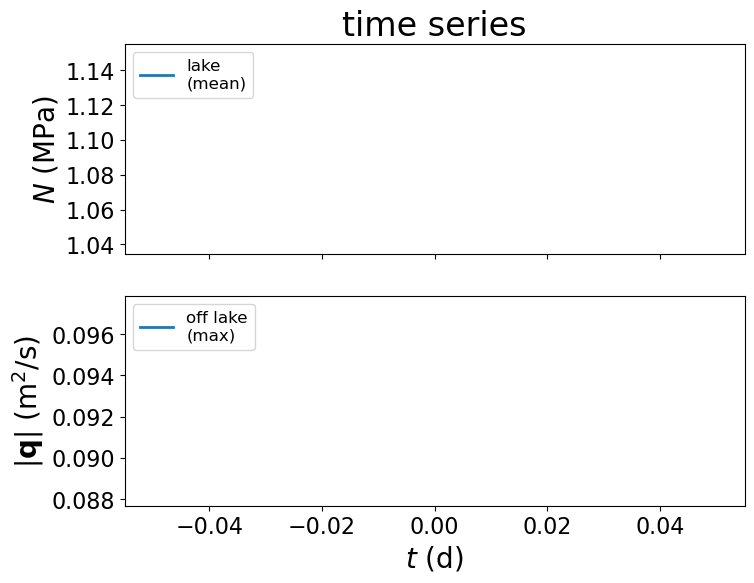

In [3]:
%matplotlib inline

N_mean = np.mean(N,axis=(1,2))
q_max = np.max(q_m,axis=(1,2))
# N_mean = np.mean(N[storage>1e-2],axis=(1,2)) #TODO
# q_max = np.max(q_m[storage<1e-2],axis=(1,2)) #TODO

plt.figure(figsize=(8,6))
plt.subplot(211)
plt.title(r'time series',fontsize=24)
plt.plot(t*365./3.154e7,N_mean/1e6,linewidth=2,label='lake\n(mean)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$N$ (MPa)',fontsize=20)
plt.gca().xaxis.set_ticklabels([])
plt.legend(fontsize=12,loc='upper left')


plt.subplot(212)
plt.plot(t*365./3.154e7,q_max,linewidth=2,label='off lake\n(max)')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(r'$|\mathbf{q}|$ (m$^2/$s)',fontsize=20)
plt.xlabel(r'$t$ (d)',fontsize=20)
plt.legend(fontsize=12,loc='upper left')
# plt.xlim(0,20)
# plt.savefig('plot-'+resultsname)
plt.show()
plt.close()

Save png's for movie:

/gpfsm/dnb34/tdirs/batch/slurm.43167465.agstubbl/ipykernel_1849/2490540636.py:72: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,t.max()*365./3.154e7)
/gpfsm/dnb34/tdirs/batch/slurm.43167465.agstubbl/ipykernel_1849/2490540636.py:83: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0,t.max()*365./3.154e7)


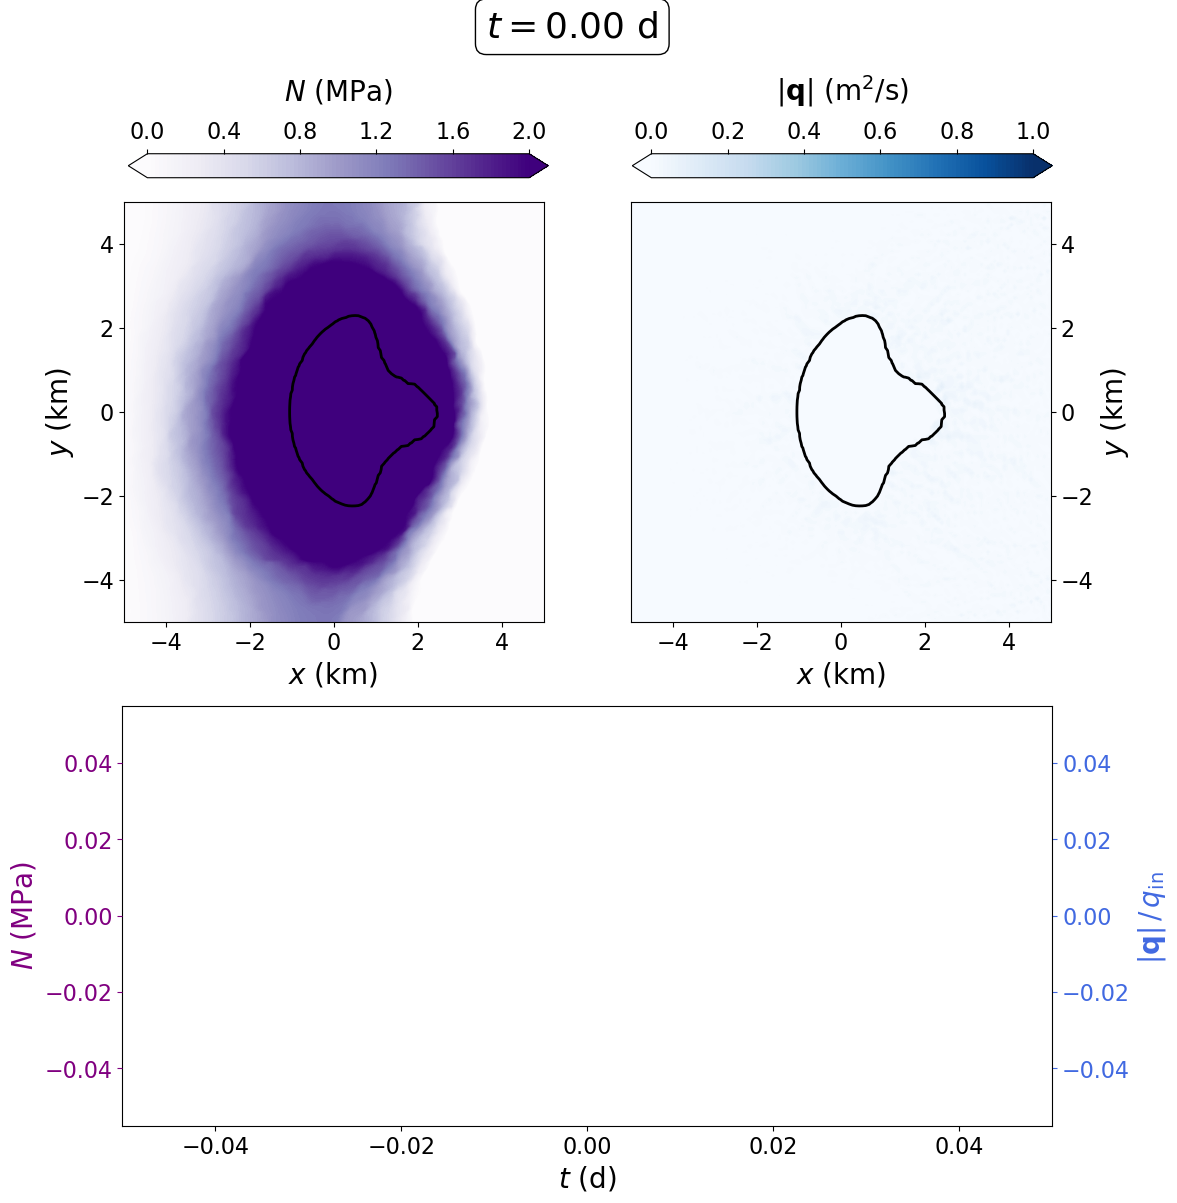

In [5]:
#!rm -r movie_{resultsname}
#!mkdir movie_{resultsname}

N_mean = np.mean(N,axis=(1,2))
q_max = np.max(q_m,axis=(1,2))
ind_ = q_max[q_max**2>0].size-1
ind_

# use agg backend for saving pngs
mpl.use('agg')

j=0
# ind = np.arange(0,t.size,1)

# ind = np.array([t.size-1])
ind = np.array([ind_])
%matplotlib inline

for i in ind:
    print('saved image '+str(j+1)+' out of '+str(ind.size)+' \r',end='')
    
    if np.abs(b[i,:,:]).min()>1e-7:
        fig = plt.figure(figsize=(12,12))
                
        plt.suptitle(r'$t=$'+'{:.2f}'.format(365*t[i]/3.154e7)+' d',y=1.04,fontsize=26,bbox=dict(boxstyle='round', facecolor='w', alpha=1))

        plt.subplot(221)
        N_i = N[i,:,:]
        storage_i = storage[i,:,:]
        p1 = plt.contourf(X/1e3,Y/1e3,N_i/1e6,levels=np.linspace(0,2,100),cmap='Purples',extend='both')
        plt.contour(X/1e3,Y/1e3,storage_i,levels=[0.001],colors='k',linestyles='-',linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.xlabel(r'$x$ (km)',fontsize=20)
        plt.ylabel(r'$y$ (km)',fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        cbar_ax = fig.add_axes([0.13, 0.9, 0.35, 0.02])
        cbar = plt.colorbar(p1,orientation='horizontal',ticks=np.linspace(0,2,6),cax=cbar_ax)
        cbar.set_label(r'$N$ (MPa)',fontsize=20,labelpad=15)
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')

        
        plt.subplot(222)
        q_i = q_m[i,:,:]
        p2 = plt.contourf(X/1e3,Y/1e3,q_i,cmap='Blues',levels=np.linspace(0,1,100),extend='both')
        plt.contour(X/1e3,Y/1e3,storage_i,levels=[0.001],colors='k',linestyles='-',linewidths=2)
        plt.gca().set_aspect('equal', 'box')
        plt.xlabel(r'$x$ (km)',fontsize=20)
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()
        plt.ylabel(r'$y$ (km)',fontsize=20)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        cbar_ax = fig.add_axes([0.55, 0.9, 0.35, 0.02])
        cbar = plt.colorbar(p2,orientation='horizontal',ticks=np.linspace(0,1,6),cax=cbar_ax)
        cbar.set_label(r'$|\mathbf{q}|$ (m$^2/$s)',fontsize=20,labelpad=15)
        cbar.ax.tick_params(labelsize=16)
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.ax.xaxis.set_label_position('top')
        
        plot = plt.subplot(212)
        ax2 = plt.gca()
        plt.plot(t[0:i]*365./3.154e7,N_mean[0:i]/1e6,color='purple',linestyle='--',linewidth=3,zorder=100)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.gca().tick_params(axis='y', colors="purple")
        plt.ylabel(r'$N$ (MPa)',fontsize=20,color='purple')
        # plt.ylim(0.03,-0.01)
        plt.xlabel(r'$t$ (d)',fontsize=20)
        plt.xlim(0,t.max()*365./3.154e7)

        plt.gca().twinx()
        plt.plot(t[0:i]*365./3.154e7,q_max[0:i],color='royalblue',linewidth=3,zorder=10)
        plt.gca().yaxis.set_label_position("right")
        plt.gca().yaxis.tick_right()   
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.gca().tick_params(axis='y', colors="royalblue")
        plt.ylabel(r'$|\mathbf{q}|\,/\,q_\mathrm{in}$ ',fontsize=20,color='royalblue')
        plt.xlabel(r'$t$ (d)',fontsize=20)
        plt.xlim(0,t.max()*365./3.154e7)
        # plt.ylim(0.0,0.5)
        # plt.savefig('./movie_'+resultsname+'/'+str(j),bbox_inches='tight')
        plot.set_zorder(ax2.get_zorder()+1)
        plot.set_frame_on(False)
        plt.show()
        plt.close()
        j+=1

In [5]:
0%24

0